
=== SCENARIO 1: Feature Selection Impact ===

Training model WITHOUT feature selection
MSE: 0.0210
R2 Score: 0.9916

Training model WITH feature selection
Selected features: ['Age', 'Avg_Daily_Usage_Hours', 'Affects_Academic_Performance', 'Sleep_Hours_Per_Night', 'Mental_Health_Score', 'Conflicts_Over_Social_Media', 'Academic_Level_Graduate', 'Academic_Level_High School', 'Country_Bangladesh', 'Country_Denmark', 'Country_France', 'Country_Germany', 'Country_India', 'Country_Japan', 'Country_Mexico', 'Country_Netherlands', 'Country_Pakistan', 'Country_Spain', 'Country_Switzerland', 'Country_Turkey', 'Country_UAE', 'Country_USA', 'Most_Used_Platform_Facebook', 'Most_Used_Platform_LINE', 'Most_Used_Platform_LinkedIn', 'Most_Used_Platform_TikTok', 'Most_Used_Platform_Twitter', 'Most_Used_Platform_VKontakte', 'Most_Used_Platform_WhatsApp', 'Usage_to_Sleep_Ratio']
MSE: 0.0373
R2 Score: 0.9851

Best approach for Scenario 1: No Feature Selection

=== SCENARIO 2: Normalization Impact ===

Trai

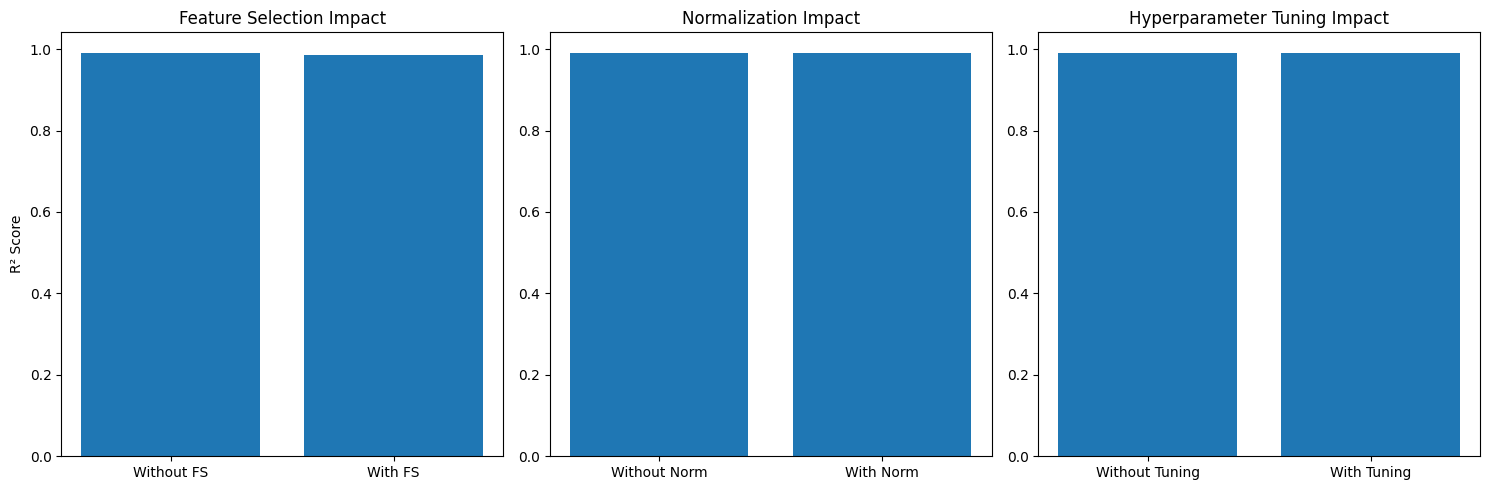

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor  # or any other model

# Load processed dataset
df = pd.read_csv('../dataset/processed_data.csv')

# Split target and features
X = df.drop('Addicted_Score', axis=1)
y = df['Addicted_Score']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Function to evaluate model
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"MSE: {mse:.4f}")
    print(f"R2 Score: {r2:.4f}")
    return mse, r2

# SCENARIO 1: With vs Without Feature Selection
print("\n=== SCENARIO 1: Feature Selection Impact ===")
results_scenario1 = {}

# Without feature selection
print("\nTraining model WITHOUT feature selection")
model_no_fs = RandomForestRegressor(random_state=42)
model_no_fs.fit(X_train, y_train)
y_pred_no_fs = model_no_fs.predict(X_test)
mse_no_fs, r2_no_fs = evaluate_model(y_test, y_pred_no_fs)
results_scenario1['No Feature Selection'] = {'MSE': mse_no_fs, 'R2': r2_no_fs}

# With feature selection
print("\nTraining model WITH feature selection")
selector = SelectKBest(f_regression, k=20)  # Select top 20 features
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)
selected_features = X.columns[selector.get_support()]
print(f"Selected features: {selected_features.tolist()}")

model_fs = RandomForestRegressor(random_state=42)
model_fs.fit(X_train_selected, y_train)
y_pred_fs = model_fs.predict(X_test_selected)
mse_fs, r2_fs = evaluate_model(y_test, y_pred_fs)
results_scenario1['With Feature Selection'] = {'MSE': mse_fs, 'R2': r2_fs}

# Determine which approach is better
best_approach_s1 = 'With Feature Selection' if r2_fs > r2_no_fs else 'No Feature Selection'
print(f"\nBest approach for Scenario 1: {best_approach_s1}")

# Use the best approach for next scenario
if best_approach_s1 == 'With Feature Selection':
    X_train_best_s1 = X_train_selected
    X_test_best_s1 = X_test_selected
else:
    X_train_best_s1 = X_train
    X_test_best_s1 = X_test

# SCENARIO 2: With vs Without Normalization
print("\n=== SCENARIO 2: Normalization Impact ===")
results_scenario2 = {}

# Without normalization (using best from scenario 1)
print("\nTraining model WITHOUT normalization")
model_no_norm = RandomForestRegressor(random_state=42)
model_no_norm.fit(X_train_best_s1, y_train)
y_pred_no_norm = model_no_norm.predict(X_test_best_s1)
mse_no_norm, r2_no_norm = evaluate_model(y_test, y_pred_no_norm)
results_scenario2['No Normalization'] = {'MSE': mse_no_norm, 'R2': r2_no_norm}

# With normalization
print("\nTraining model WITH normalization")
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train_best_s1)
X_test_normalized = scaler.transform(X_test_best_s1)

model_norm = RandomForestRegressor(random_state=42)
model_norm.fit(X_train_normalized, y_train)
y_pred_norm = model_norm.predict(X_test_normalized)
mse_norm, r2_norm = evaluate_model(y_test, y_pred_norm)
results_scenario2['With Normalization'] = {'MSE': mse_norm, 'R2': r2_norm}

# Determine which approach is better
best_approach_s2 = 'With Normalization' if r2_norm > r2_no_norm else 'No Normalization'
print(f"\nBest approach for Scenario 2: {best_approach_s2}")

# Use the best approach for next scenario
if best_approach_s2 == 'With Normalization':
    X_train_best_s2 = X_train_normalized
    X_test_best_s2 = X_test_normalized
else:
    X_train_best_s2 = X_train_best_s1
    X_test_best_s2 = X_test_best_s1

# SCENARIO 3: With vs Without Hyperparameter Tuning
print("\n=== SCENARIO 3: Hyperparameter Tuning Impact ===")
results_scenario3 = {}

# Without hyperparameter tuning (default parameters)
print("\nTraining model WITHOUT hyperparameter tuning")
model_no_tune = RandomForestRegressor(random_state=42)
model_no_tune.fit(X_train_best_s2, y_train)
y_pred_no_tune = model_no_tune.predict(X_test_best_s2)
mse_no_tune, r2_no_tune = evaluate_model(y_test, y_pred_no_tune)
results_scenario3['No Tuning'] = {'MSE': mse_no_tune, 'R2': r2_no_tune}

# With hyperparameter tuning
print("\nTraining model WITH hyperparameter tuning")
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(X_train_best_s2, y_train)
print(f"Best parameters: {grid_search.best_params_}")

model_tune = grid_search.best_estimator_
y_pred_tune = model_tune.predict(X_test_best_s2)
mse_tune, r2_tune = evaluate_model(y_test, y_pred_tune)
results_scenario3['With Tuning'] = {'MSE': mse_tune, 'R2': r2_tune}

# Determine which approach is better
best_approach_s3 = 'With Tuning' if r2_tune > r2_no_tune else 'No Tuning'
print(f"\nBest approach for Scenario 3: {best_approach_s3}")

# FINAL SUMMARY
print("\n=== FINAL SUMMARY ===")
print(f"Best for Feature Selection: {best_approach_s1}")
print(f"Best for Normalization: {best_approach_s2}")
print(f"Best for Hyperparameter Tuning: {best_approach_s3}")

# Create a summary table
results_df = pd.DataFrame({
    'Scenario 1': pd.Series(results_scenario1),
    'Scenario 2': pd.Series(results_scenario2),
    'Scenario 3': pd.Series(results_scenario3)
})
print("\nResults Summary:")
print(results_df)

# Visualize results
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.bar(['Without FS', 'With FS'], [results_scenario1['No Feature Selection']['R2'], results_scenario1['With Feature Selection']['R2']])
plt.title('Feature Selection Impact')
plt.ylabel('R² Score')

plt.subplot(1, 3, 2)
plt.bar(['Without Norm', 'With Norm'], [results_scenario2['No Normalization']['R2'], results_scenario2['With Normalization']['R2']])
plt.title('Normalization Impact')

plt.subplot(1, 3, 3)
plt.bar(['Without Tuning', 'With Tuning'], [results_scenario3['No Tuning']['R2'], results_scenario3['With Tuning']['R2']])
plt.title('Hyperparameter Tuning Impact')

plt.tight_layout()
plt.show()